In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2425)

## Data generation

In [2]:
# Good, but 2 CLASSES ONLY
#   alpha increases "spread"
#   beta increases "jitter"
def generate_data(n, alpha=0.1, beta=1, initial_point=[0, 0], groups=[0, 1], add_bias=True):
    data = np.empty((n, 2))
    # Define an initial point
    data[0, :] = initial_point
    
    # Randomly "scale" the upcoming reflection
    a = np.random.uniform(low=(-1-alpha), high=(-1+alpha), size=n)
    
    # "Flip" previous point and add some noise
    for k in range(1, n):
        data[k, ] = a[k]*data[k-1, :] + beta*np.random.normal(0, 1, size=2)
    
    # Add a bias variable
    if add_bias:
        data = np.hstack((np.ones((n, 1)), data))
    
    # Labels are two classes (0, 1), strictly alternating, because of "flipping" above
    labs = np.array(groups*(n//2 + 1))[:n]
    
    return data, labs

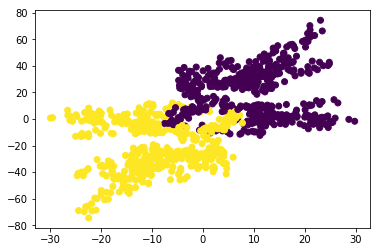

In [3]:
demo_data, demo_labs = generate_data(1000, initial_point=[10, 10])

plt.scatter(demo_data[:, 1], demo_data[:, 2], c=demo_labs)

## Auxiliary functions

In [4]:
def make_sets(data, labels, props, shuffle=True):
    
    if sum(props) != 1:
        raise ValueError("proportions must sum to 1")
    
    m = data.shape[0]
    idx = np.random.permutation(m) if shuffle else range(m)
    
    sets = []
    cursor = 0
    
    for p in props:
        dset = data[idx, :][cursor:(cursor+int(p*m)), :]
        sets.append(dset)
        lset = labels[idx][cursor:(cursor+int(p*m))]
        sets.append(lset)
        
        cursor = int(p*m)
    
    return sets

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = make_sets(demo_data, demo_labs, [0.6, 0.2, 0.2])

In [6]:
X_train.shape

(600, 3)

In [7]:
y_val.shape

(200,)

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [9]:
sigmoid(1)

0.7310585786300049

In [10]:
def predict(features, weights):
    Z = np.dot(features, weights)
    return sigmoid(Z)

In [11]:
# Must initialise weights to be different
# Otherwise complete cancellation can lead to failure
init_weights = np.random.uniform(-0.1, 0.1, 3)

In [12]:
pp = predict(X_train, init_weights)
pp.shape, pp.sum()

((600,), 301.9140243759815)

In [13]:
def classify(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

In [14]:
classify(pp)[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [15]:
def accuracy(predicted, actual):
    return np.mean(predicted == actual)

In [16]:
def plot_boundary(data, labels, weights, subdivs=200, alpha=0.2):
    
    fig, ax = plt.subplots()
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    
    xmin, xmax = ax.get_xlim()
    xstep = (xmax-xmin)/subdivs
    ymin, ymax = ax.get_ylim()
    ystep = (ymax-ymin)/subdivs
    
    grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep].reshape(2, -1).T
    n = grid.shape[0]
    grid_with_bias = np.hstack((np.ones((n, 1)), grid))
    
    ax.contourf(np.arange(xmin, xmax, xstep), np.arange(ymin, ymax, ystep),
               predict(grid_with_bias, weights).reshape(-1, subdivs).T,
               alpha = alpha)
    
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    return None

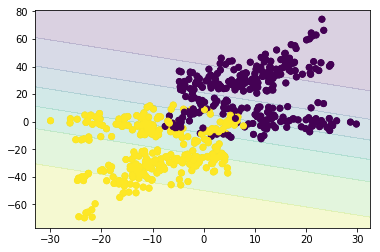

In [17]:
plot_boundary(X_train, y_train, init_weights)

## Simple logistic regression

In [18]:
def get_cost(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Average cost per observation
    return cost/m
    

In [19]:
get_cost(X_train, y_train, init_weights)

0.3468848459825562

In [20]:
def get_grad(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Average gradient over all observations
    grad = np.dot(features.T, (preds - labels)) / m
    
    return grad

In [21]:
get_grad(X_train, y_train, init_weights)

array([0.00652337, 2.00053475, 3.23295849])

In [22]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        weights = weights - rate*grad
        
        new_cost = get_cost(features, labels, weights)
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [47]:
optw, ch = train(X_train, y_train, init_weights, rate=0.01, iters=2000, report_level=10)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.3468848459825562
0010 | 0.173345943420615
0020 | 0.16190461403622777
0030 | 0.15821423304255522
0040 | 0.1566565764036577
0050 | 0.15590989669322847
0060 | 0.15552476149235428
0070 | 0.15531663389630118
0080 | 0.15520056217928901
0090 | 0.15513437643565609
0100 | 0.15509602148047613
0110 | 0.15507352328110605
0120 | 0.15506020095400255
Tolerance reached - terminating early!

Training complete!
Iterations completed: 121
Final cost: 0.15506020095400255


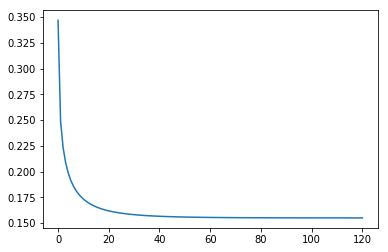

In [48]:
plt.plot(ch)

In [49]:
optw

array([ 0.04952156, -0.19769644, -0.15890006])

In [50]:
preds = predict(X_val, optw)
preds_classes = classify(preds)

accuracy(preds_classes, y_val)

0.945

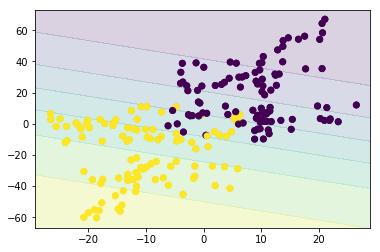

In [51]:
plot_boundary(X_val, y_val, init_weights)

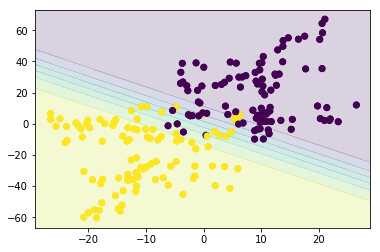

In [52]:
plot_boundary(X_val, y_val, optw)

## Variable step size

Two approaches:

* Decrease at a set rate (e.g. exponential decay)
* Adaptive decrease (e.g. backtracking)

Second approach is perhaps more expensive, but mitigated if we assume that step size **decreases** as we approach the optimum. Offers more flexibility.

In [53]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        
        new_weights = weights - rate*grad
        new_cost = get_cost(features, labels, new_weights)
        
        while np.isnan(new_cost) or new_cost > cost:
            if verbose:
                print("  Rate change!", rate, "->", rate/2)
            rate = rate/2
            new_weights = weights - rate*grad
            new_cost = get_cost(features, labels, new_weights)
        
        weights = new_weights
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [61]:
optw, ch = train(X_train, y_train, init_weights, rate=1, iters=2000, report_level=5)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.3468848459825562
  Rate change! 1 -> 0.5
  Rate change! 0.5 -> 0.25
  Rate change! 0.25 -> 0.125
  Rate change! 0.125 -> 0.0625
0005 | 0.1577818462749291
0010 | 0.15521173410559386
0015 | 0.15504782053343835
Tolerance reached - terminating early!

Training complete!
Iterations completed: 19
Final cost: 0.15504131780809402


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


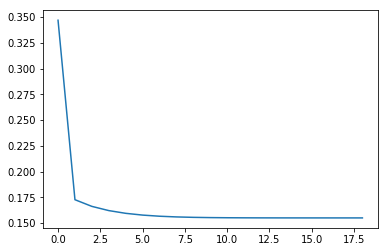

In [62]:
plt.plot(ch)

Note sharper elbow in plot.

For now, we don't see much adaptation _during_ training... though it means we don't have to be quite so careful with our initial rate (we can just set it "too high" and let the backtracking work its way back down).

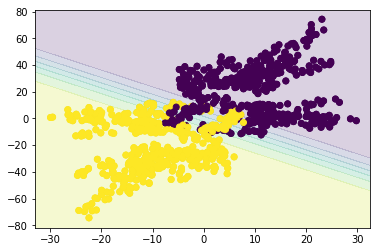

In [63]:
plot_boundary(demo_data, demo_labs, optw)

## Regularisation

Large weights increase sensitivity of output to small changes in input. Better if we can "spread" this sensitivity over the weights, to reduce reliance on any individual weights, thus improving robustness (and hopefully improving generalisation).

Discourage large weights by adding a penalty term to the cost function: (squared) L2-norm of all weights.

In [64]:
def get_reg_cost(features, labels, weights, gamma=100):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Add regularisation term
    cost = cost + (gamma/2)*(weights**2).sum()
    
    # Average cost per observation
    return cost/m
    

In [65]:
get_cost(X_train, y_train, init_weights)

0.3468848459825562

In [66]:
def get_reg_grad(features, labels, weights, gamma=100):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Gradient of cost function
    grad = np.dot(features.T, (preds - labels))
    
    # Add gradient of regularisation term
    grad = grad + gamma*weights.sum()
    
    # Average grad per observation
    return grad/m

In [67]:
get_grad(X_train, y_train, init_weights)

array([0.00652337, 2.00053475, 3.23295849])

In [70]:
optw, ch = train(X_train, y_train, init_weights, rate=1, iters=2000, report_level=5)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.3468848459825562
  Rate change! 1 -> 0.5
  Rate change! 0.5 -> 0.25
  Rate change! 0.25 -> 0.125
  Rate change! 0.125 -> 0.0625
0005 | 0.1577818462749291
0010 | 0.15521173410559386
0015 | 0.15504782053343835
Tolerance reached - terminating early!

Training complete!
Iterations completed: 19
Final cost: 0.15504131780809402


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


Virtually no difference here, but we'll see the effect once we have more dimensions...